In [27]:
#%%

# IMPORT LIBRARIES

## OS
import os

# MANAGE
import pandas as pd
import numpy as np

## FIT
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from sklearn.metrics import r2_score

## DECOMPOSITION
from sklearn.decomposition import NMF
from scipy.linalg import svd

## GRAPHICS
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

## I/O
import zipfile
import requests
import pickle

## DOWNLOAD
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)


## CREATE PATHS / DIRECTORIES 

# path to home directory (the location of this file)
path0 = !pwd
path = path0.n

os.chdir(path)

#Check if directories exist - creat directories if needed

paths = {}
paths['data'] = './data'
paths['census'] = paths['data'] + '/census'
paths['onet'] = paths['data'] + '/onet'

[os.makedirs(pth, exist_ok=True) for pth in paths.values()]


## GENERAL FUNCTIONS 
### NORMALIZATION
# Statistic normalization - subtract mean, scale by standard deviation
def norm_stat(vec, weights = False):
    '''
    Normalizes a vector v-v.mean())/v.std() 
    '''
    if weights:
        return  np.mean(abs(vec - vec.mean()))  
    return (vec-vec.mean())/vec.std()

# Algebraic normalization - dot product
def norm_dot(vec, weights = False):
    '''
    Normalizes the columns of a DataFrame (dot product)
    '''
    if weights:
        return  np.sqrt(vec @ vec)
    
    return vec / np.sqrt(vec @ vec)

def scale(vec, weights = False):
    stop_divide_by_zero = 0.00000001
    if weights:
        return (vec.max()-vec.min() + stop_divide_by_zero)
    return (vec-vec.min())/(vec.max()-vec.min() + stop_divide_by_zero)

### SELECTION 
def is_string(a):
    '''
    typically used for Boolean masking in Pandas, e.g.  
               df[df['column'].apply(is_string)] 
    returns all rows in df where df['column'] has a string value   
    '''
    return isinstance(a,str)


## CLASSES

### DATA DICTIONARY 

class    Datadic: 
    def __init__(self):
        # Set up FIPS CODES for states and regions
        fips_codes_exists = os.path.isfile('data/state-geocodes-v2016.xls')
        if not fips_codes_exists:
            print('*** FIPS State Geocodes is missing. Downloading from Census...')
            # !curl -o ./data/state-geocodes-v2016.xls -O https://www2.census.gov/programs-surveys/popest/geographies/2016/state-geocodes-v2016.xls
            download_url('https://www2.census.gov/programs-surveys/popest/geographies/2016/state-geocodes-v2016.xls','./data/state-geocodes-v2016.xls')
            print('*** Complete.')

        self.dfips = pd.read_excel('data/state-geocodes-v2016.xls')[5:] #five first rows are comment
        self.name_to_fips = self.dfips.set_index('Unnamed: 3')['Unnamed: 2'].to_dict()
        self.fips_to_name = self.dfips.set_index('Unnamed: 2')['Unnamed: 3'].to_dict()
        self.translate_fips = {**self.name_to_fips,**self.fips_to_name}
        
        self.state_to_abbrev = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO',
                'Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI',
                'Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
                'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO',
                'Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM',
                'New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
                'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX',
                'Utah': 'UT','Vermont': 'VT','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'}
        self.abbrev_to_state = {v: k for k, v in self.state_to_abbrev.items()}
        self.translate_state_abbrev = {**self.state_to_abbrev,**self.abbrev_to_state}
        
        #Set up CENSUS/ACS PUMS DATA DICTIONARY
        pums_datadic_exists = os.path.isfile('./data/census/PUMS_Data_Dictionary.csv')
        if not pums_datadic_exists:
            print('*** Census ACS/PUMS Data Dictionary is missing. Downloading from Census...')
            # !curl -o ./data/census/PUMS_Data_Dictionary.csv -O https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2017.csv
            download_url('https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2017.csv','./data/census/PUMS_Data_Dictionary.csv')
            print('*** Complete.')
        self.census = pd.read_csv("data/census/PUMS_Data_Dictionary.csv").drop_duplicates()
        self.census_variable_definitions = self.census.groupby('RT').first()['Record Type'].to_dict()      
            
    def fips(self,name_or_fipsnr):
        nn = datadic.abbrev_to_state.get(name_or_fipsnr,name_or_fipsnr)
        return self.translate_fips.get(nn)
    
    def state_abbrev(self,name_or_abbrev):
        return self.translate_state_abbrev.get(name_or_abbrev)
    
    def census_def(self,variable_code):
        return self.census_variable_definitions.get(variable_code)

    # All definitions containing a select string
    def clk(self,census_col,search_string):
        return self.census[census_col].fillna('nan').apply(lambda x: search_string.lower() in x.lower())
    
    def census_about(self,search_string):
        return self.census[self.clk('Record Type',search_string) | self.clk('Unnamed: 6',search_string) ]
    
datadic = Datadic()


class Onet:
    '''
    Onet() is an object based on the Onet labor market database. 

    my_onet.source  - string: URL for importing the onet database from source
    my_onet.path    - string: local path to the directory where the onet database is stored. (set in 'paths' dictionary)
    my_onet.name    - string: the prefix of stored files, e.g. zipped DB:      path + '/'+ name +'.zip'
    my_onet.toc()   - function: returns table of contents for onet database

   # Data in Onet database
    my_onet.data()
                    - function: returns dataset named by label.
    my_onet.matrix() 
                    - function: returns onet dataset in matrix form
    my_onet.n_matrix() 
                    - function: normalized onet matrix
 
   
    '''
    def __init__(self,path = paths['onet'], name = 'onet', source = 'https://www.onetcenter.org/dl_files/database/db_23_3_excel.zip'):
        
        self.path = path
        self.name = name
        self.source = source
        self.dataset = {}
        self.matrix_dic = {}
        
        zip_file = path + '/'+ name +'.zip'
        onet_exists = os.path.isfile(zip_file)
        if not onet_exists:
            print('*** Onet database does not exist. Downloading from Onet...')
            #shcmd = 'curl -o '+zip_file+' -O '+source
            #!$shcmd'
            download_url(source,zip_file)
            print('*** Complete.')
        
        self.zip = zipfile.ZipFile(zip_file)
        self.tocdf = self.make_toc()
    
    def make_toc(self,sep ='.'):
        '''
        Creates table of contents for Onet Database, returns as my_onet.tocdf (dataframe)
        '''
        nlst = np.array(self.zip.namelist())
        dr = nlst[0]
        nl = pd.DataFrame(nlst)
        self.tocdf = pd.DataFrame(nl[0].apply(lambda x: np.char.split(x.replace(dr,''),sep = '.'))[1:].to_dict(),
                                    index = ['name','extension']).T
        return self.tocdf
    
    def toc(self, name_contains= False, extension = False):
        '''
        Returns table of contents for Onet Database (dataframe) masked by string and/or extension
        '''
        selection = self.tocdf
        if extension:
            selection = selection[selection['extension'] == extension  ]['name']
        if name_contains:
            search_string = name_contains
            selection = selection[selection['name'].apply(lambda x: search_string.lower() in x.lower())]['name']
        return selection
         
    
    def data(self,label, socp_shave = 6):
        '''
        Returns onet dataset named 'label'
        '''
        # If dataframe in dictionary:  
        if label in self.dataset.keys():
            df = self.dataset[label]
            df['SOCP_shave'] = df['O*NET-SOC Code'].apply(lambda x: x.replace('.','').replace('-','')).apply(lambda x: x[:socp_shave])
            return self.dataset[label]

        # If dataframe NOT in dictionary: 
        # If pickled dataframe does not exist, create from zipped excel
        # Read pickled dataframe into dictionary
        pkl_name = self.path +'/'+ self.name +'_'+ label +'.pkl'
        pkl_exists = os.path.isfile(pkl_name)

        if not pkl_exists:
            print('*** '+label+'.pkl does not exist. Creating...')
            xlsx_name = self.zip.namelist()[0] + label +'.xlsx'
            pd.read_excel(self.zip.extract(xlsx_name)).to_pickle(pkl_name)
            print('*** Complete.')
        df = pd.read_pickle(pkl_name)
        df['SOCP_shave'] = df['O*NET-SOC Code'].apply(lambda x: x.replace('.','').replace('-','')).apply(lambda x: x[:socp_shave])
        self.dataset[label] = df                              
        return self.dataset[label]
    
    def grpby(self, label, columns = ['Scale Name','Element Name'], data_value = 'Data Value', scale_name = 'Level'):
        grp = pd.DataFrame(self.data(label).copy().groupby(columns).apply(lambda x: x[data_value].values))
        return grp

    def matrix(self,label, xx = 'Element Name',  yy = 'SOCP_shave',socp_shave = 6 , data_value = 'Data Value', scale_name = 'Level',
                show = 'mean', norm = False):
        '''
        Converts onet dataset into a matrix 
        xx          - matrix columns
        yy          - matrix index
        scale_name  - value category 
        data_value  - data values
        socp_shave  - number of digits in 'shaved' SOCP number
        show        - output matrix shows 'mean'(default), 'std' or 'count' (relevant for groupby socp_shave)
        '''
        if not (label,xx,yy,socp_shave,data_value,scale_name,norm) in self.matrix_dic.keys():
            print('*** Matrix not in dictionary. Constructing....')
            columns = ['Scale Name',yy,xx] # Default columns
            grpb = self.data(label,socp_shave = socp_shave).groupby(columns)
            mat_mean   = grpb.mean().loc[scale_name][data_value].unstack()
            mat_std    = grpb.std().loc[scale_name][data_value].unstack()
            mat_count = grpb.count().loc[scale_name][data_value].unstack().T.iloc[[0]].T
            if norm:
                w = mat_mean.apply(lambda col: norm(col,weights = True) )
                mat_mean = mat_mean.apply(norm)
                mat_std = mat_std/w
            self.matrix_dic[label,xx,yy,socp_shave,data_value,scale_name,norm] = {
                'mean':mat_mean,'std':mat_std,'count':mat_count}
            print('*** Complete')
        return self.matrix_dic[label,xx,yy,socp_shave,data_value,scale_name,norm][show]
    
    def n_matrix(self,label, 
                 norm = 'stat', 
                 xx = 'Element Name',  yy = 'SOCP_shave' ,data_value = 'Data Value', scale_name = 'Level',
                 axis = 1, socp_shave = 6):
        '''
        Converts onet dataset into a normalized matrix 
        xx          - matrix columns
        yy          - matrix index
        scale_name  - value category 
        data_value  - data values
        socp_shave  - number of digits in 'shaved' SOCP number
        norm        - type of normalization
        axis        - axis of normalization
        '''
        norm_type = {'stat': norm_stat, 'dot' : norm_dot }
        mat = self.matrix(label,data_value = data_value , scale_name = scale_name, socp_shave = socp_shave)
        return mat.apply(norm_type[norm],axis = axis)
       
# Instantiate Onet() as 'onet'
onet = Onet()            

#%%    

class   Census:
    '''
    Census() is an object containing census ACS/PUMS data 
    my_census.source    - string: URL for importing the census data from US Census online
    my_census.path      - string: local path to the directory where the census data is stored. (set in 'paths' dictionary)
    my_census.name      - string: the prefix of stored files, e.g. pickle:      path + '/'+ name +'.pkl'

    my_census.data(self,state, socp_shave = n)
                        - function: returns the acs/pums for 'state', with an SOCP number of 'n' digits (default n=6)
    my_census.dataset   - dataframe: acs/pums data for a state (state abbreviation used for naming)
    my_census.import_from_source(self,state)
                        - function: imports data for 'state' from my_census.source and converts to pickled dataframe 


    # my_census.state    – String: name of state, e.g. 'California', or abbreviation, e.g. 'CA'
    # my_census.data     – DataFrame: imported census ACS/PUMS data (from pickle)
    # my_census.workers  – DataFrame: people fulfilling 'workers' criteria (see below)
    # my_census.occupations         – DataFrame: Occupations of the workers (groupby SOCP-number)
    
    # my_census.workers_occupations(age_low = 40, age_high = 65, std_max = 0.5, socp_granularity = 5):
    #      - Function: populates my_census.workers / .occupations according to criteria
    #          – Workers: age_low (default 40)  and age_high (default 65)
    #          – Occupations: socp_granularity (default 5) ; the length of the SOCP number, default 5 digits.
    
    '''

    def __init__(self,path = paths['census'], name = 'census', 
                 source = 'https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/'):
        self.path = path
        self.name = name
        self.source = source
        self.dataset = {}
        
    
    def data(self,state, socp_shave = 6):
        '''
        READ CENSUS/ACS PUMS DATABASE. Search order: Dictionary, Pickle; Create dictionary/pickle if non-existent.
        socp_shave  : number of digits in 'shaved' SOCP number
        '''
        state_abbr = datadic.state_to_abbrev.get(state,state)
        pkl_name = self.path +'/'+ self.name +'_'+ state_abbr +'.pkl'
        pkl_exists = os.path.isfile(pkl_name)
        if not pkl_exists:
            self.import_from_source(state)
        df = pd.read_pickle(pkl_name)
        df['SOCP_shave'] = df['SOCP'].apply(lambda x: x[:socp_shave].replace('X','0') if type(x)==str else x)
        self.dataset[state_abbr] = df
        return self.dataset[state_abbr]


    # Create and execute shell command fetching state census zip-file 
    def import_from_source(self,state):
        print('*** Downloading '+state+' ACS/PUMS dataset from US Census...')
        state_abbr = datadic.state_to_abbrev.get(state,state)
 #       shcmd = "curl -o "+self.path+'/'+self.name+"_tmp.zip -O "+ self.source +self.state_zipfile_name(state_abbr)
 #       ! $shcmd
        download_url(self.source +self.state_zipfile_name(state_abbr),self.path+'/'+self.name+"_tmp.zip")
        print('*** Reformatting...')
        with zipfile.ZipFile(self.path+'/'+self.name+"_tmp.zip", 'r') as zipObj:
            zipObj.extractall(self.path)
        csv_filename = self.path+'/psam_p'+datadic.fips(state)+'.csv'
        pkl_filename = self.path+'/'+self.name+'_'+state_abbr+'.pkl'
        pd.read_csv(csv_filename).to_pickle(pkl_filename)
        ! rm $csv_filename 
        print('*** Complete.')
        return 

    def state_zipfile_name(self,state_abbr):
        return 'csv_p'+state_abbr.lower()+'.zip'



# Instantiate Census() as 'census'
census = Census()


#%%

# # MATRIX-FACTORIZATION: DIMENSIONALITY REDUCTION & ARCHETYPING

# ## CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# ## Use non-zero matrix factorization for clustering
# ## Use singular value decomposition first state for determining overall similarity

class Archetypes:
    '''
    Archetypes: Performs NMF of order n on X and stores the result as attributes. 
    Archetypes are normalized: cosine similarity a(i) @ a(i) = 1. 
    Atributes:
        my_archetypes.n         - order / number of archetypes
        my_archetypes.X         - input matrix
        
        my_archetypes.model     - NMF model 
        my_archetypes.w         - NMF w-matrix 
        my_archetypes.h         - NMF h-matrix
        
        my_archetypes.o         - occupations x archetypes matrix (from w-matrix)
        my_archetypes.on        - occupations x normalized archetypes matrix (from w-matrix) - SOCP number as index. 
        my_archetypes.occ       - occupations x normalized archetypes matrix - Occupation names as index
        
        my_archetypes.f         - features x archetypes matrix (from h-matrix)
        my_archetypes.fn        - features x normalized archetypes matrix
        
    '''
    def __init__(self,X,n):
        self.n = n
        self.X = X
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w = self.model.fit_transform(self.X)
        self.o = pd.DataFrame(self.w,index=self.X.index)
        self.on = self.o.T.apply(norm_dot).T
        self.occ = self.on.copy()
        self.occ['Occupations'] = self.occ.index
#        self.occ['Occupations'] = self.occ['Occupations'].apply(onet_socp_name)
        self.occ = self.occ.set_index('Occupations')
        self.h = self.model.components_
        self.f = pd.DataFrame(self.h,columns=X.columns)
        self.fn =self.f.T.apply(norm_dot).T
        
    def plot_features(self,fig_scale = (1,3.5),metric='cosine', method = 'single'): 
        '''
        Plot Archetypes as x and features as y. 
        Utilizes Seaborn Clustermap, with hierarchical clustering along both axes. 
        This clusters features and archetypes in a way that visualizes similarities and diffferences
        between the archetypes. 
        
        Archetypes are normalized (cosine-similarity): dot product archetype[i] @ archetype[i] = 1.
        The plot shows intensities (= squared feature coefficients) so that the sum of intensities = 1.  

        fig_scale: default values (x/1, y/3.5) scales the axes so that all feature labels are included in the plot.
        
        For other hyperparameters, see seaborn.clustermap
     
        '''
        sns.clustermap(np.square(self.fn),robust = True, z_score=0,figsize=(
            self.X.shape[1]/fig_scale[1],self.n/fig_scale[0]),method = method,metric = metric)


    def plot_occupations(self,fig_scale = (1,3.5),metric='cosine', method = 'single'):
        '''
        Plot Archetypes as x and occupations as y. 
        Utilizes Seaborn Clustermap, with hierarchical clustering along both axes. 
        This clusters occupations and archetypes in a way that visualizes similarities and diffferences
        between the archetypes. 
        
        Occupations are normalized (cosine-similarity): dot product occupation[i] @ occupation[i] = 1.
        The plot shows intensities (= squared feature coefficients) so that the sum of intensities = 1.  

        fig_scale: default values (x/1, y/3.5) scales the axes so that all feature labels are included in the plot.
        
        For other hyperparameters, see seaborn.clustermap
     
        '''   
        sns.clustermap(np.square(self.occ).T, figsize=(
            self.X.shape[0]/fig_scale[1],self.n/fig_scale[0]),method = method,metric = metric)

        
class Xfit:
    '''
    Xfit is a 'fit-as-an-object' solution:
        my_fit = Xfit(X,y,Xsamples=False, my_regressor, itr, xval) 
            does the following:
            0. SAMPLES X - unless Xsamples is 'False' [default value], X is replaced by n random samples of itself  
            1. SPLITS X and y into test and training sets. 
            2. FITS a cross-validation, slicing the training data into 'xval' slices : cross_validate(regressor,X_train.values, y_train.values, cv=xval) 
            3. BOOTSTRAPS: Repeats (1-2) 'itr' number of times
            4. RETURNS RESULTS as attributes:
                my_fit.X          – List: The original X input data
                my_fit.itr        – Number of iterations / fits
                my_fit.y          – List: The original y input data
                my_fit.xval       – Number of slices in the cross validation
                my_fit.fit        – Dictionary: the 'itr' number of cross-validated fits, including estimators
                my_fit.y_test     – Dictionary: the y_test (list) for each fit
                my_fit.y_predict  – Dictionary: the predicted y for each fit
                my_fit.scores     – Pandas.DataFrame: validation scores for all fits 
                my_fit.score      – Dictionary: the mean score and standard deviation. 
                my_fit.features_importances        – Dictionary: feature_importances for all fits (for estimators with '.feature_importance_' as an attribute )
                my_fit.feature_importance          – Pandas.DataFrame: the average feature importances and standard deviations.           
    '''
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import cross_val_score
    from sklearn import linear_model
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    import xgboost as xgb  

    def __init__(self,X,y,Xsamples=False,regressor = xgb.XGBRegressor(),itr = 10, xval = 3):      
        # FITTING
        n = xval  
        feature_names = X.columns
        res = {}
        ypred = {}
        ytest = {}
        scor = {}
        feat_imp = {}       
        for i in range(itr):
            if Xsamples:
                X_train, X_test, y_train, y_test = train_test_split(X.sample(Xsamples,axis=1), y, test_size=0.2)
            else:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            res_xboo = cross_validate(regressor,X_train.values, y_train.values, cv=n, return_estimator=True)
            ytest[i] = y_test
            res[i] = res_xboo
            ypred[i] = [res_xboo['estimator'][j].predict(X_test.values) for j in range(n)]
            scor[i] = [res_xboo['estimator'][j].score(X_test.values,y_test.values) for j in range(n)]
            feat_imp[i] = [res_xboo['estimator'][j].feature_importances_ for j in range(n)]
        scor_tot = np.concatenate(np.array(list(scor.values())))
        feat_tot = pd.concat([pd.DataFrame(feat_imp[i]) for i in range(itr)])
#       # feat_tot.columns = X.columns
        feat_tot.reset_index(inplace=True,drop = True)
        feat_mean = pd.concat([feat_tot.mean(),feat_tot.std()],axis=1)
        feat_mean.columns = ['mean','std']
        feat_mean['ratio'] = feat_mean['std']/feat_mean['mean']      
        # STORING RESULTS AS ATTRIBUTES
        self.X = X
        self.y = y
        self.fit = res
        self.y_predict = ypred
        self.y_test = ytest
        self.scores = pd.DataFrame(scor).T
        self.score = {'mean':scor_tot.mean(), 'std':scor_tot.std()}
        self.feature_importances = feat_imp
        self.feature_importance = feat_mean.sort_values('mean',ascending=False)
        self.itr =itr
        self.xv = xval



class Svd:
    ''''
    Singular value decomposition-as-an-object
        my_svd = Svd(X) returns
        my_svd.u/.s/.vt – U S and VT from the Singular Value Decomposition (see manual)
        my_svd.f        – Pandas.DataFrame: f=original features x svd_features
        my_svd.o        - Pandas.DataFrame: o=occupations x svd_features
    '''
    def __init__(self,X):
        self.u,self.s,self.vt = svd(np.array(X))
        self.f = pd.DataFrame(self.vt,columns=X.columns)
        self.o = pd.DataFrame(self.u,columns=X.index)
        




#%%


In [10]:
cdc = census.data('DC')
ab = onet.matrix('Abilities')

Text(0.5,1,'O*NET DATABASE: ABILITIES REQUIRED BY OCCUPATIONS\n')

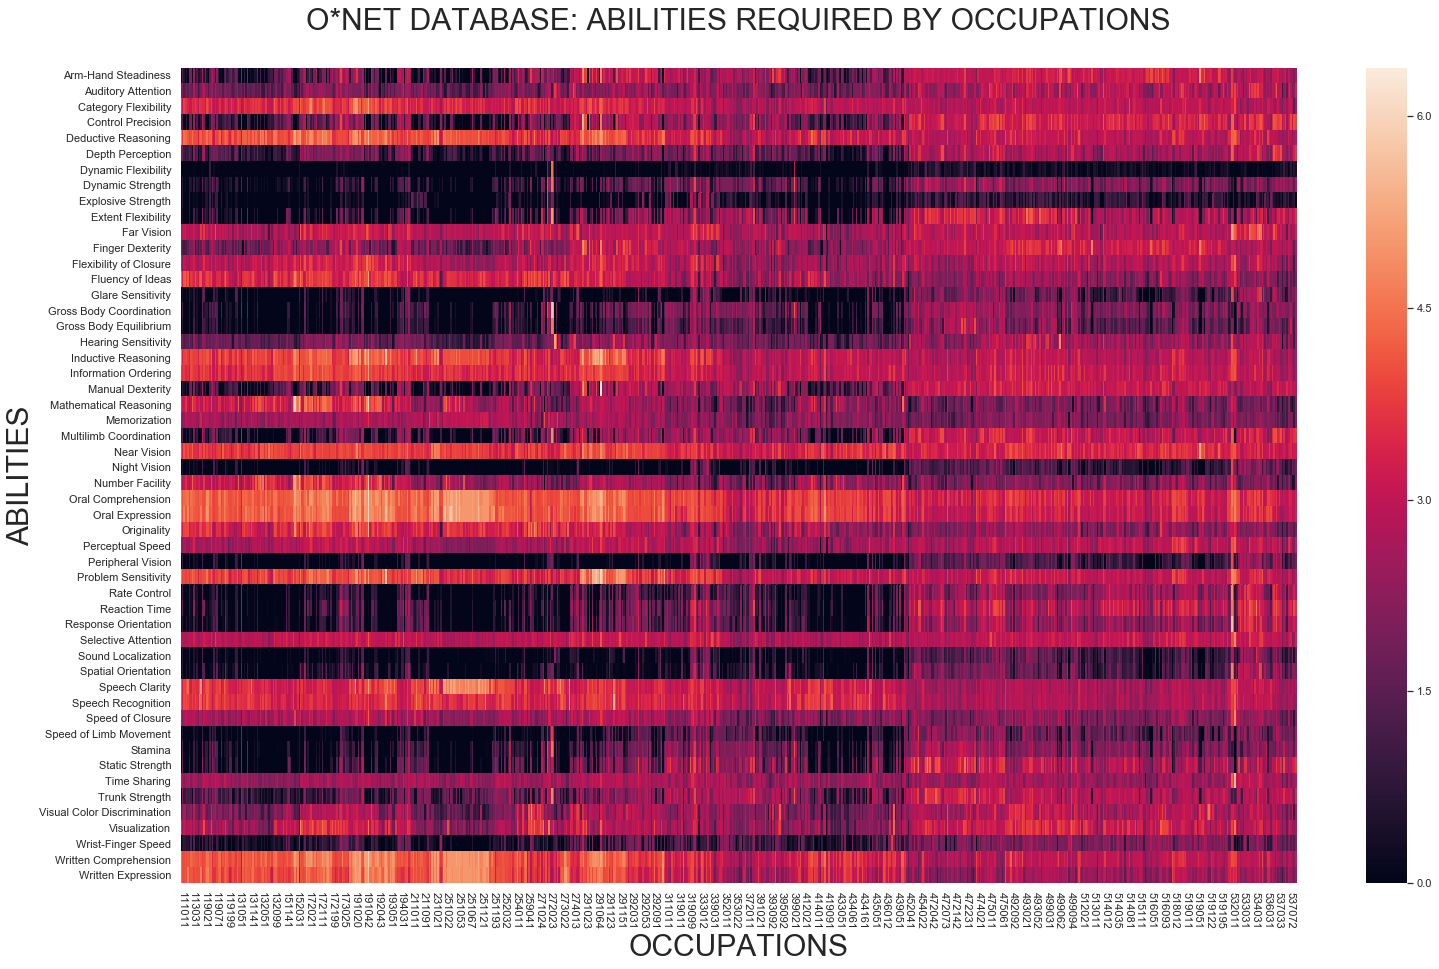

In [13]:
plt.figure(figsize = (25,15))
sns.heatmap(onet.matrix('Abilities').T)
plt.xticks(rotation=-90)
plt.xlabel('OCCUPATIONS',fontsize = 30)
plt.ylabel('ABILITIES',fontsize = 30)
plt.title('O*NET DATABASE: ABILITIES REQUIRED BY OCCUPATIONS\n', fontsize = 30)

In [24]:
stop_divide_by_zero = 0.0000001 # 
ab2 = ab.apply(lambda x: (x-x.min())/(x.max()-x.min() + stop_divide_by_zero))

Text(0.5,1,'O*NET DATABASE: ABILITIES REQUIRED BY OCCUPATIONS\n')

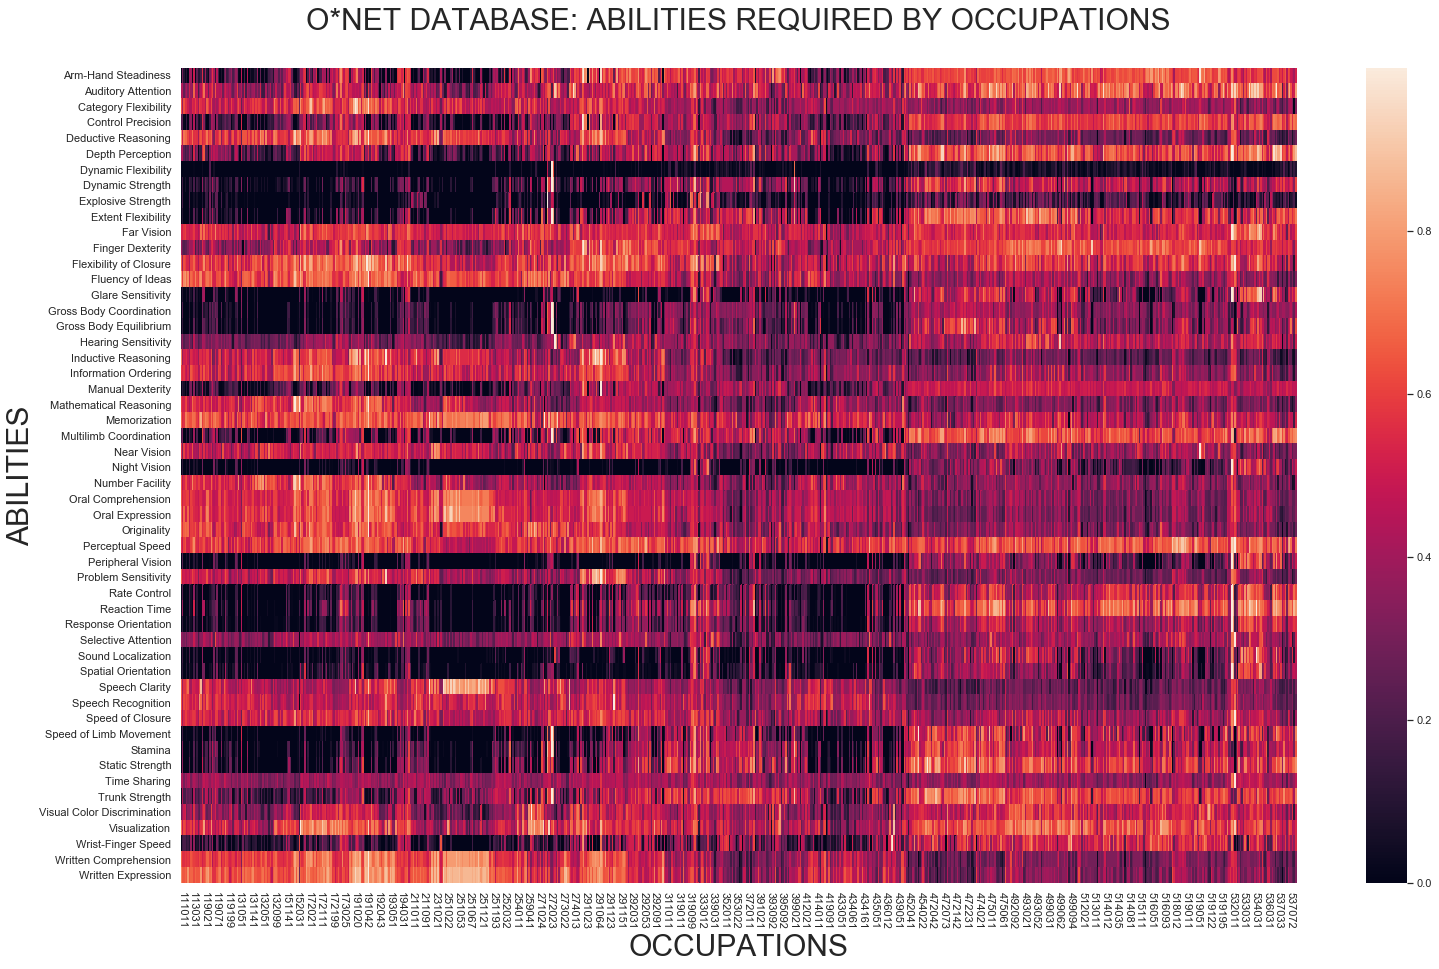

In [25]:
plt.figure(figsize = (25,15))
sns.heatmap(ab2.T)
plt.xticks(rotation=-90)
plt.xlabel('OCCUPATIONS',fontsize = 30)
plt.ylabel('ABILITIES',fontsize = 30)
plt.title('O*NET DATABASE: ABILITIES REQUIRED BY OCCUPATIONS\n', fontsize = 30)

In [28]:
ab3 = onet.matrix('Abilities',norm=scale)

*** Matrix not in dictionary. Constructing....
*** Complete


Text(0.5,1,'O*NET DATABASE: ABILITIES REQUIRED BY OCCUPATIONS\n')

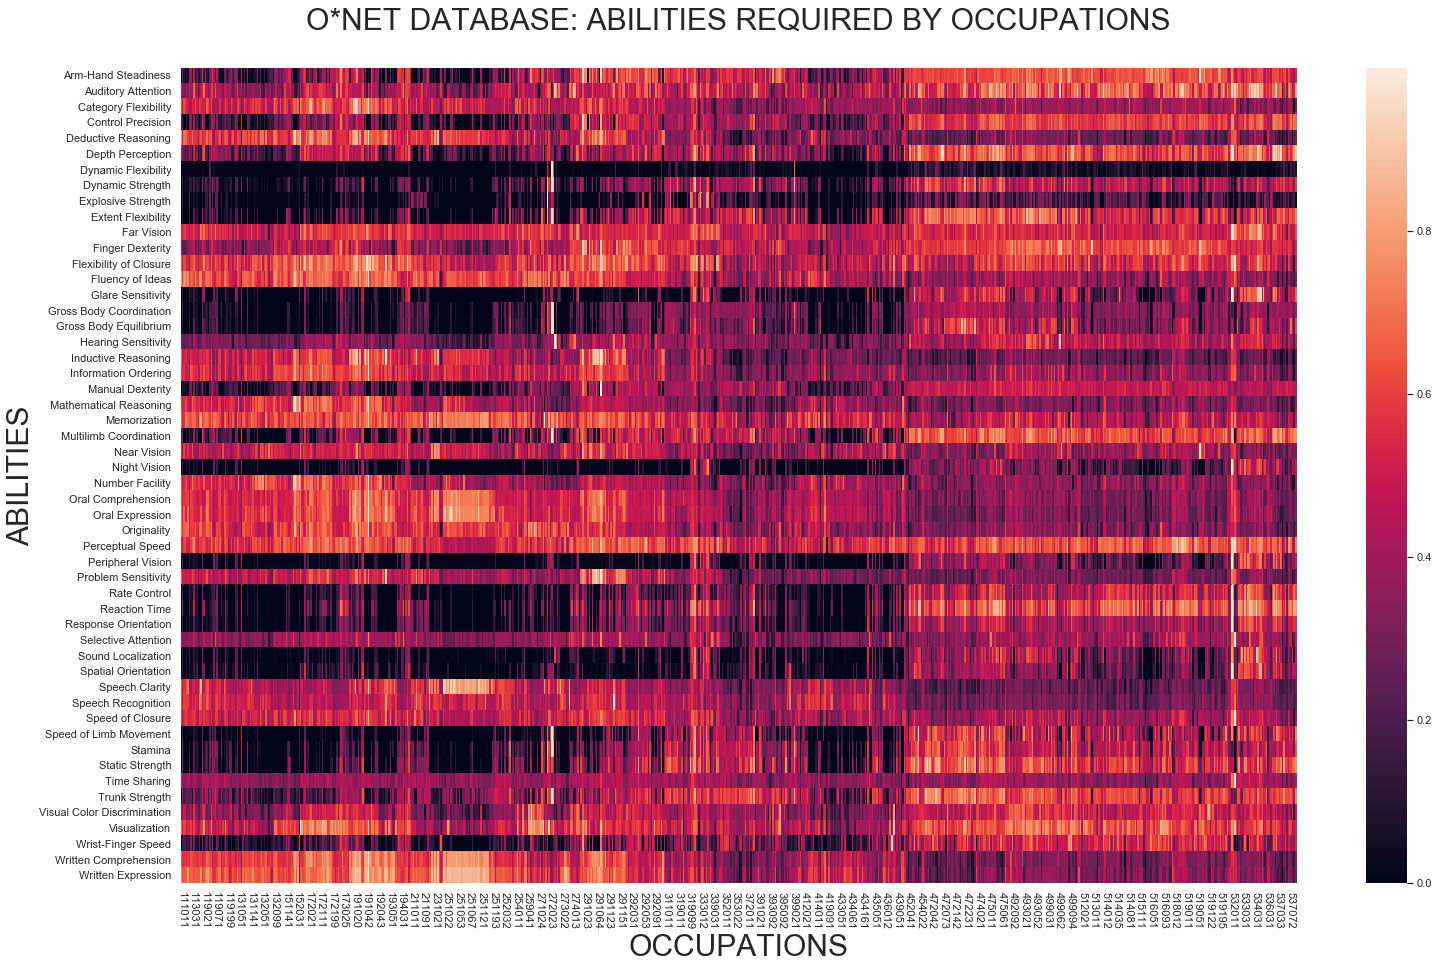

In [29]:
plt.figure(figsize = (25,15))
sns.heatmap(ab3.T)
plt.xticks(rotation=-90)
plt.xlabel('OCCUPATIONS',fontsize = 30)
plt.ylabel('ABILITIES',fontsize = 30)
plt.title('O*NET DATABASE: ABILITIES REQUIRED BY OCCUPATIONS\n', fontsize = 30)